# PinaColADA Phase 2 Notebook 

The Youniverse dataset consists of 3 main sub-datasets : the channel dataset, the video dataset and the timeseries data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import axes
import matplotlib.dates as mdates
from matplotlib import dates
from matplotlib import ticker
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
from ThymeBoost import ThymeBoost as tb
import random
from datetime import datetime, timedelta

### Importing data 

For this phase we only use the channels dataset and the timeseries dataset

In [2]:
DIR = "data/"
PATH_CHANNELS_DST = DIR + "df_channels_en.tsv.gz"
PATH_TIME_SERIES_DST = DIR + "df_timeseries_en.tsv.gz"
PATH_COMMENTS_AUTHOR_DST = DIR + "num_comments_authors.tsv.gz"
PATH_COMMENTS_DST = DIR + "num_comments.tsv.gz"
PATH_METADATA_DST = DIR + "yt_metadata_en.jsonl.gz"
PATH_METADATA_HELPER = DIR + "yt_metadata_helper.feather"

In [3]:
channels = pd.read_csv(PATH_CHANNELS_DST, sep = '\t', compression='gzip')
channels['join_date']= pd.to_datetime(channels['join_date'])
channels.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [4]:
timeseries = pd.read_csv(PATH_TIME_SERIES_DST, sep = '\t', compression='gzip')
timeseries['datetime']= pd.to_datetime(timeseries['datetime'])
timeseries['delta_views'] = timeseries['delta_views'].round(decimals = 3)
timeseries['subs'] = timeseries['subs'].round(decimals = 3)
timeseries['delta_subs'] = timeseries['delta_subs'].round(decimals = 3)
timeseries.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000,650.222,0.000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111,1046.000,395.778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083,1501.500,455.500,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250,1750.000,248.500,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600,2008.300,258.300,6,0,0


### Channel data exploration

In [5]:
channels.describe()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights
count,1.364700e+05,136470.000000,1.364700e+05,136470.000000
mean,2.466022e+05,699.784231,3.570087e+05,7.349363
std,1.150096e+06,4524.980928,2.711139e+05,5.277328
min,1.000000e+04,10.000000,3.000000e+00,2.086500
25%,1.888575e+04,70.000000,1.161305e+05,4.231500
50%,4.240000e+04,175.000000,3.015670e+05,6.444000
75%,1.370000e+05,443.000000,5.704942e+05,9.243500
max,1.121395e+08,461923.000000,1.030844e+06,53.150500


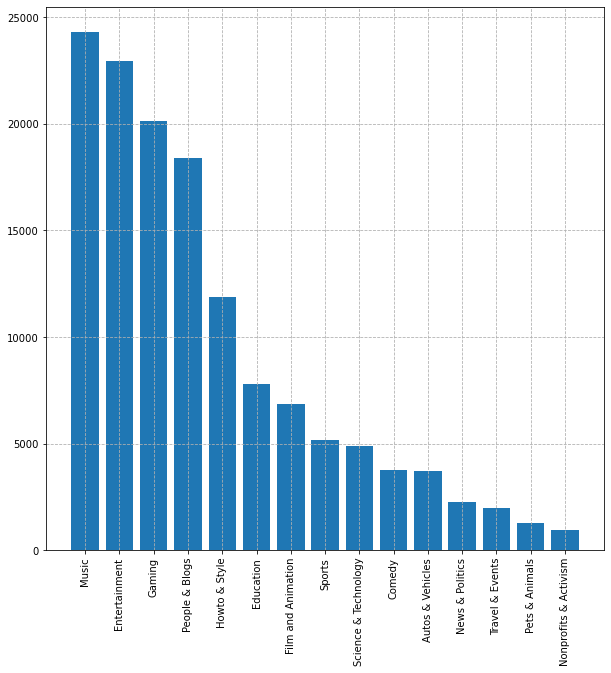

In [6]:
# Group the channels by categories
categories = channels.groupby(['category_cc']).size().to_frame()
categories.rename(columns={0:'count'}, inplace=True)

# Sort and plot the resulting data
categories.sort_values(by='count', ascending=False, inplace=True)
plt.figure(figsize=(10,10))
plt.grid(linestyle='--')
plt.bar(categories.index, categories['count'])
plt.xticks(rotation = 90)
plt.show()


We can see that there is a minority of categories that concentrate a large part of the channels: this can be explained by the fact that these are categories with much broader subjects than others (such as for example Entertainment compared to Pets & Animals) but also by the fact that some can be used by actors fondamentally different than typical Youtube content creators (like Music with artist channels).


In [7]:
# Power law definition : required for fitting the data
def power_law(x, a, k):
    return a * (x ** k)

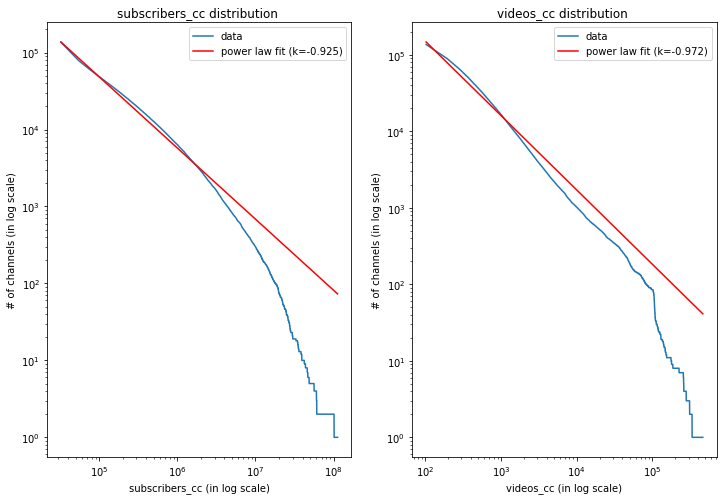

In [8]:
# For each category to plot :
power_law_cat = ['subscribers_cc', 'videos_cc']
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

for idx, cat in enumerate(power_law_cat):
    
    # Group the data into bins
    array_hist = ax[idx].hist(channels[cat], bins=5000,log=True,cumulative=-1,histtype='step')
    ax[idx].clear()
    
    # Fit the data to find a suitable power law
    popt, pcov = curve_fit(power_law,array_hist[1][1:],  array_hist[0])
    
    # Plot both the data and the fitted function
    ax[idx].loglog(array_hist[1][1:],array_hist[0], label='data')
    ax[idx].loglog(array_hist[1][1:], power_law(array_hist[1][1:], *popt), 'r-', label='power law fit (k=%.3f)' % tuple(popt)[1])
    ax[idx].set_title(f'{cat} distribution ')
    ax[idx].set_ylabel('# of channels (in log scale)')
    ax[idx].set_xlabel(f'{cat} (in log scale)')
    ax[idx].legend()

plt.show()
                                                                              

The subscribers count follows a power law : the vast majority of Youtube channels have a low number of subscribers while only a few channel concentrate the major part of subscriptions.
We can also make this statement about the number of published videos per channels

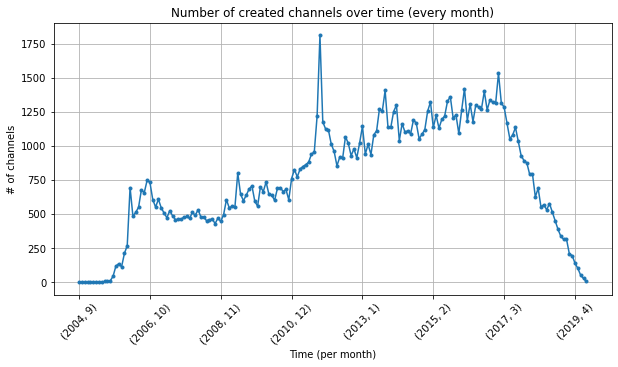

In [9]:
# Count the value of join_date 
creation_dt_df = channels['join_date'].value_counts().to_frame()

# Add missing values (if there was no channel created during a certain month we have to add 0-entry to our dataframe)
idx = pd.date_range(creation_dt_df.index.min(), creation_dt_df.index.max())
creation_dt_df.index = pd.DatetimeIndex(creation_dt_df.index)
creation_dt_df = creation_dt_df.reindex(idx, fill_value=0)

# Group the data by year and month to get an approrpiate scale
creation_dt_df = creation_dt_df.groupby([(creation_dt_df.index.year), (creation_dt_df.index.month)]).sum()

# Plot the final dataset 
creation_dt_df.plot(kind='line',figsize=(10,5), grid='--', legend=False, rot=45, marker=".")
plt.title('Number of created channels over time (every month)')
plt.ylabel('# of channels')
plt.xlabel('Time (per month)')
plt.show()

We can see that there is a considerable attraction for Youtube from its creation in 2005 and in the 2010s followed by a significant drop from 2017 where less and less channels are created.

# Timeseries data exploration

In [10]:
# Group the channel month 
datetimes = timeseries.groupby(pd.Grouper(key="datetime", freq="M")).channel.nunique()
channels_tot = len(timeseries.channel.unique())

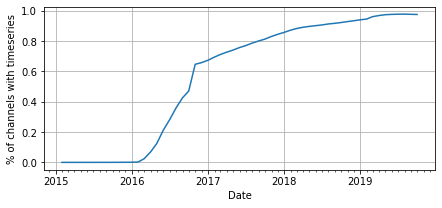

In [11]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(1, figsize=(7,3), sharey=True, sharex=True,
                       gridspec_kw={"wspace": 0.05})
# sns.lineplot(data=(datetimes / channels_tot), ax=ax)
ax.plot(datetimes / channels_tot)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.set_xlabel("Date")
ax.set_ylabel("% of channels with timeseries")
ax.grid()

From the graph above, we can see that there is relatively big expansion of the number of channels from 2016 to 2017 and grows slower after. From that we decide to pick only timeseries starting timestamp in January 2017. Also we decide to take channels that have at least 140 timestamps (which correspond to ~3 years)

In [12]:
timeseries_filtered = timeseries[timeseries.datetime > pd.to_datetime("2017-1-1")]
print("We know have {} datapoints".format(len(timeseries_filtered)))

We know have 16732615 datapoints


### Timestamps uniformization

In [13]:
channel_timeseries = pd.pivot_table(timeseries_filtered, values='delta_views', 
                                index=['datetime'], 
                                columns=['channel'])
print("Without uniformization, we have {} rows.".format(len(channel_timeseries)))
channel_timeseries.head()

Without uniformization, we have 288 rows.


channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3c8RqSfAqYBdDjIG3UNA,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--7oyGW0N7fMf164-ZXljQ,UC--94OGFAzYDOJb0eXgMjew,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,...,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzztaOtjmaZoiLvWLagq7bg,UCzzyt9Z70MBX9RQAFVSNlpQ,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 23:00:00,2731.406,27667.057,NaN,78790.542,45266.219,58624.651,NaN,NaN,230144.542,3141.141,...,1723.201,4365.896,NaN,17874.796,14840.513,NaN,NaN,11938.087,8823.580,57680.059
2017-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,389.792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-08 23:00:00,4190.594,32073.417,NaN,83433.521,58383.031,261201.391,NaN,NaN,211393.042,3132.073,...,2196.625,2537.089,NaN,21798.781,15995.781,NaN,NaN,16928.234,11129.797,68525.880
2017-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,413.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-15 23:00:00,8811.448,60385.818,NaN,176154.271,105656.375,436874.953,NaN,NaN,410550.208,5420.714,...,4063.500,11802.484,NaN,44051.906,24833.911,NaN,NaN,23935.083,17847.375,141159.036


When setting up our data structure, we noticed that there was some small issues in the timeseries datapoints timsestamp : as the data was not crawled at exactly the same time for all channels, there are not the same all across. If we look at the table just above, you can see that there are timestamps that should have been pooled at around the same time that have a 2-hour difference, resulting in additional rows for parts of the dataset. We have timestamps for one day at 23h00 and for the day after at 1h00 or 00h00.

Since the hour of the time isn't relevant in our study, we decided to substract 2-hour from the timestamp : for the timestamp indicating 23h00, this won't change anything but for the timestamp indicating 00h00 or 01h00, this will change the current timestamp day to the previous day, which uniforms timestamps for all channels. 

In [14]:
# Project the timestamp to the correct day
uniform_datetime = timeseries_filtered.copy(deep=True)
uniform_datetime.datetime = uniform_datetime.datetime - timedelta(hours = 2)
# Drop the time to only keep the day
uniform_datetime.datetime = pd.to_datetime(uniform_datetime.datetime).dt.date
uniform_channel_timeseries = pd.pivot_table(uniform_datetime, values='delta_views', 
                                index=['datetime'], 
                                columns=['channel'])
print("With uniformization, we have {} rows.".format(len(channel_timeseries)))
uniform_channel_timeseries.head()

With uniformization, we have 288 rows.


channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3c8RqSfAqYBdDjIG3UNA,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--7oyGW0N7fMf164-ZXljQ,UC--94OGFAzYDOJb0eXgMjew,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,...,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzztaOtjmaZoiLvWLagq7bg,UCzzyt9Z70MBX9RQAFVSNlpQ,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2731.406,27667.057,NaN,78790.542,45266.219,58624.651,NaN,NaN,230144.542,3141.141,...,1723.201,4365.896,389.792,17874.796,14840.513,NaN,NaN,11938.087,8823.580,57680.059
2017-01-08,4190.594,32073.417,NaN,83433.521,58383.031,261201.391,NaN,NaN,211393.042,3132.073,...,2196.625,2537.089,413.875,21798.781,15995.781,NaN,NaN,16928.234,11129.797,68525.880
2017-01-15,8811.448,60385.818,NaN,176154.271,105656.375,436874.953,NaN,NaN,410550.208,5420.714,...,4063.500,11802.484,1117.375,44051.906,24833.911,NaN,NaN,23935.083,17847.375,141159.036
2017-01-22,4207.583,31155.448,NaN,170651.932,118148.547,237834.172,NaN,NaN,351185.609,4501.188,...,1467.172,18982.250,0.000,40054.531,20701.083,NaN,NaN,28294.255,8019.599,89166.245
2017-01-29,0.000,0.000,NaN,0.000,0.000,0.000,NaN,NaN,0.000,0.000,...,0.000,0.000,97.125,0.000,0.000,NaN,NaN,0.000,1184.635,0.000


There is still some NaN values in the which is normal because not every channel have all timestamps.

### Timestamp distribution

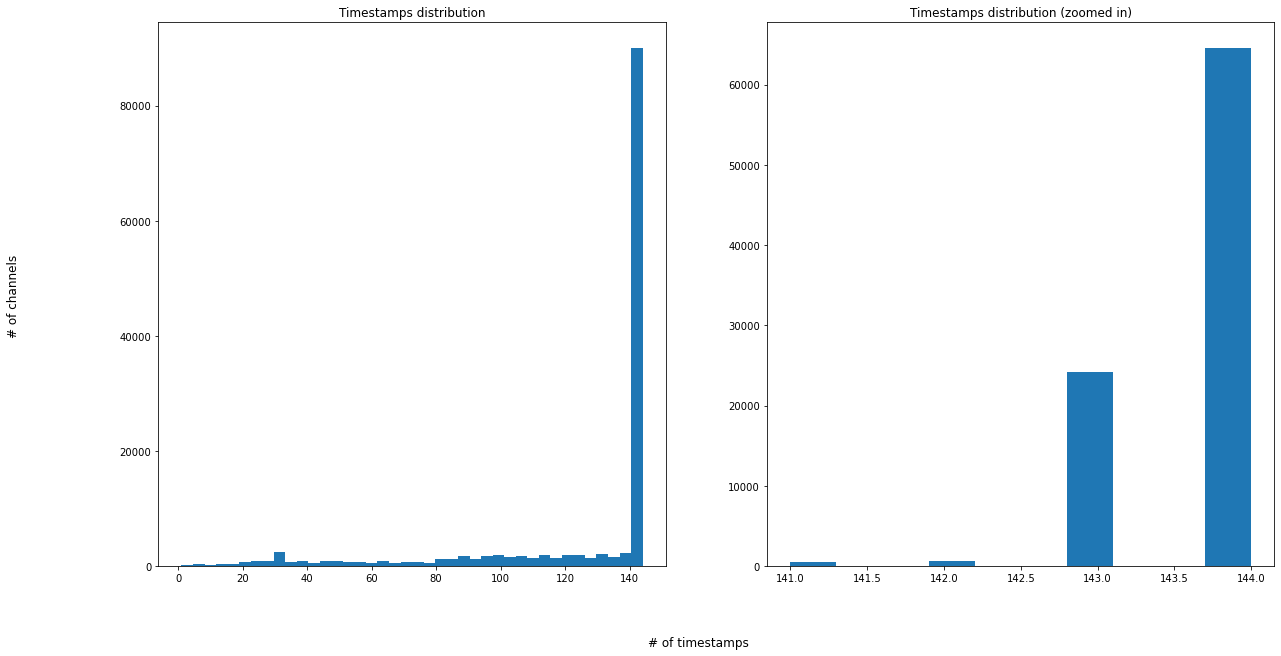

In [15]:
timeseries_sizes = uniform_channel_timeseries.count().to_frame()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].hist(timeseries_sizes[0], bins=40)
axes[0].set_title('Timestamps distribution')

axes[1].hist(timeseries_sizes[timeseries_sizes[0]>140], bins=10)
axes[1].set_title('Timestamps distribution (zoomed in)')
fig.supxlabel('# of timestamps')
fig.supylabel('# of channels')
plt.show()


Here you can see that we have the correct number of timestamp that we found in the graph above. Because of this given distribution, we decided to only keep timseries with a small amount of missing timestamps.

In [16]:
big_timeseries_sizes = timeseries_sizes[timeseries_sizes.values >= 142]
long_timeseries = timeseries[timeseries['channel'].isin(big_timeseries_sizes.index)]
print(len(long_timeseries))
long_timeseries.head()

14947209


,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
117,UCXhkGgooXHDNwgJXmoTSN7g,Music,2016-03-21 00:00:00,1.407062e+07,16179.750,6443.250,0.000,832,0,1
118,UCXhkGgooXHDNwgJXmoTSN7g,Music,2016-03-28 01:00:00,1.412790e+07,57276.576,6480.037,36.787,832,0,1
119,UCXhkGgooXHDNwgJXmoTSN7g,Music,2016-04-04 01:00:00,1.423378e+07,105880.357,6508.156,28.119,832,0,0
120,UCXhkGgooXHDNwgJXmoTSN7g,Music,2016-04-11 01:00:00,1.430530e+07,71514.625,6534.406,26.250,832,0,0
121,UCXhkGgooXHDNwgJXmoTSN7g,Music,2016-04-18 01:00:00,1.434464e+07,39347.281,6571.229,36.823,832,0,0


### Distribution of the mean deltaviews

The plot consist of the number of channels that have the same delta views mean accross the time serie.

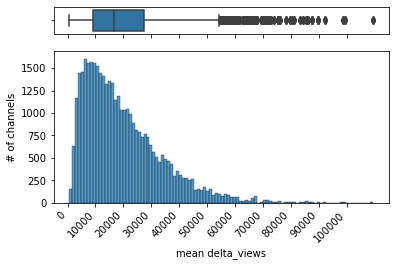

In [17]:
means = long_timeseries.groupby('channel')['delta_views'].mean().round(-1).astype(int)
vc = means.value_counts()[means.value_counts() > 6]
means = means[np.isin(means.values, (vc.index))]

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=means, ax=ax_box)
sns.histplot(x=means, ax=ax_hist)
ax_hist.set_xticks(range(0, 110000, 10000))
ax_box.set_xticks(range(0, 110000, 10000))
ax_hist.set_xlabel("mean delta_views")
ax_hist.set_ylabel("# of channels")
f.autofmt_xdate(rotation=45)

Most of the channels have delta_views's mean between 8k - 28k

### Linear Regression of delta views

Loop over all channels to compute the slope and intercept value used for the linear regression. All data are min-max normalize.

In [18]:
slopes = []
for name, channel_df in long_timeseries.groupby('channel'):
    dv = channel_df['delta_views']
    normalized_df=(dv-dv.min())/(dv.max() - dv.min())
    res = stats.linregress(range(len(channel_df)), normalized_df.values)
    slopes.append((name, res.slope, res.intercept))

Sort the list according to the slopes to see the downfall / rise of channels

In [19]:
slopes_sort = sorted(slopes, key=lambda x: x[1])

Text(0.5, 0.98, 'The most falling / stagnating / rising channels')

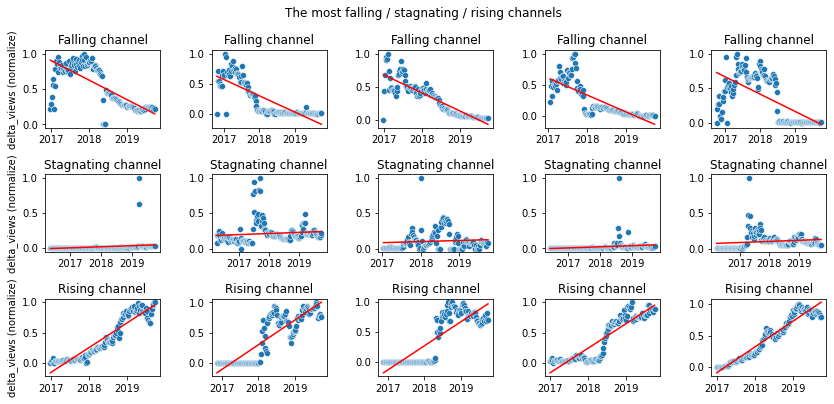

In [20]:
f, axs = plt.subplots(3, 5, figsize=(14, 6), gridspec_kw={"wspace": 0.45, "hspace": 0.6, 
                                      "height_ratios": [1, 1, 1]})

for i, ax in enumerate(axs[0]):
    idx = i
    df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
    normalized_df=(df['delta_views']-df['delta_views'].min())/(df['delta_views'].max() - df['delta_views'].min())
    sns.scatterplot(x=df['datetime'], y=normalized_df, ax=ax)
    ax.plot(df['datetime'], slopes_sort[idx][2] + range(len(df)) * slopes_sort[idx][1], color="red")
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.set_title("Falling channel")
    if i == 0:
        ax.set_ylabel("delta_views (normalize)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

for i, ax in enumerate(axs[1]):
    idx = i + int(len(slopes_sort) / 2)
    df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
    normalized_df=(df['delta_views']-df['delta_views'].min())/(df['delta_views'].max() - df['delta_views'].min())
    sns.scatterplot(x=df['datetime'], y=normalized_df, ax=ax)
    ax.plot(df['datetime'], slopes_sort[idx][2] + range(len(df)) * slopes_sort[idx][1], color="red")    
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.set_title("Stagnating channel")
    if i == 0:
        ax.set_ylabel("delta_views (normalize)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

for i, ax in enumerate(axs[2]):
    idx = -(i + 1)
    df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
    normalized_df=(df['delta_views']-df['delta_views'].min())/(df['delta_views'].max() - df['delta_views'].min())
    sns.scatterplot(x=df['datetime'], y=normalized_df, ax=ax)
    ax.plot(df['datetime'], slopes_sort[idx][2] + range(len(df)) * slopes_sort[idx][1], color="red")
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.set_title("Rising channel")
    if i == 0:
        ax.set_ylabel("delta_views (normalize)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

f.suptitle("The most falling / stagnating / rising channels")

### Dealing with outliers

As we can see there clearly, there is some channels that, according to our regression, are stagning. But is it truly the case? Look for example the plot in the middle. (2nd row, 1st column). There are some outliers that might influence the regression and hence show that the channel is stagning which is not necessarly the case. 

Let's deal with those outliers: detect them and do something with it.

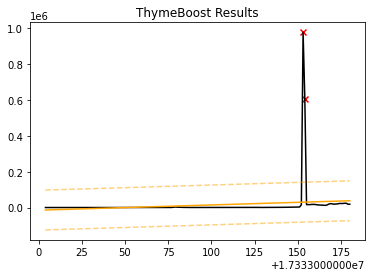

In [21]:
boosted_model = tb.ThymeBoost()
idx = int(len(slopes_sort) /2)
df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
output = boosted_model.detect_outliers(df['delta_views'],
                                       trend_estimator='linear',
                                       seasonal_estimator='fourier',
                                       global_cost='maicc',
                                       fit_type='global')
boosted_model.plot_results(output)

Here there are marked with a red X. We choose to set them to the mean value of the delta views.

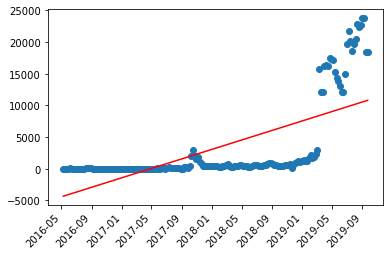

In [22]:
fig, ax = plt.subplots()
mean = output.y.mean()
output[output.outliers] = mean
res = stats.linregress(range(len(output)), output.y)
ax.scatter(df.datetime, output.y)
ax.plot(df.datetime, res.intercept + range(len(output)) * res.slope, color="red")
fig.autofmt_xdate(rotation=45)

Now we clearly see that the channel was incereasing in terms of delta views instead of stagnating as previously.

We are still unsure if we will perform such a filtering for the next phase of the project.

# Clustering
We tried several clustering methods wth a small sample that you can see below. For now, we aren't sure about which one we will choose later on. 

In [23]:
# We only keep timeseries with small number of NaN values
complete_timeseries = uniform_channel_timeseries.dropna(thresh=len(uniform_channel_timeseries) - 1, axis=1)
complete_timeseries.head()

channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,UC--LAVm36WiCmqQbekV17qQ,UC--MxpGXJ3LVD8KvlNzRlcA,UC--SaadDxRXz729rtbQqyBA,...,UCzzfu83LhPMMuhtDVA75rfw,UCzzgEOi0xR9SuflkXmTQv6g,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2731.406,27667.057,78790.542,45266.219,58624.651,230144.542,3141.141,405090.474,152664.714,218213.260,...,107774.234,50608.250,1723.201,4365.896,389.792,17874.796,14840.513,11938.087,8823.580,57680.059
2017-01-08,4190.594,32073.417,83433.521,58383.031,261201.391,211393.042,3132.073,513466.229,128403.047,166920.260,...,165696.859,66100.979,2196.625,2537.089,413.875,21798.781,15995.781,16928.234,11129.797,68525.880
2017-01-15,8811.448,60385.818,176154.271,105656.375,436874.953,410550.208,5420.714,804861.375,267081.979,180527.938,...,303092.307,269860.010,4063.500,11802.484,1117.375,44051.906,24833.911,23935.083,17847.375,141159.036
2017-01-22,4207.583,31155.448,170651.932,118148.547,237834.172,351185.609,4501.188,517145.125,268256.380,173103.469,...,50091.531,135643.083,1467.172,18982.250,0.000,40054.531,20701.083,28294.255,8019.599,89166.245
2017-01-29,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,108857.875,0.000,0.000,97.125,0.000,0.000,0.000,1184.635,0.000


In [24]:
nan_rows = complete_timeseries[complete_timeseries.isna().any(axis=1)]
print(nan_rows.index.values)
complete_timeseries.drop(nan_rows.index,inplace=True)


[datetime.date(2017, 1, 1) datetime.date(2019, 9, 29)]


We drop the rows with NaN values to balance the dropping process : we previously dropped channels with NaN values, now we drop timestamps. Also, we can see that rows with NaN values correspond to the first and last timestamp.

In [25]:
sample_set = complete_timeseries.sample(n=100,axis='columns')
date_index = sample_set.index

In [26]:
from sklearn.preprocessing import MinMaxScaler

sample_set[sample_set.columns] = MinMaxScaler().fit_transform(sample_set)
sample_set.head()


channel,UC_BI9nPyIZObtTOb4XTkAJQ,UCGsflom03oNxXy5tC3ZAybw,UCukeCps-ynaqBXpd1E-g8mA,UCW-6e9pUTG0TKhiLZLcxPHg,UCdvkFHl0TUUo7W5OqSNzmeA,UChzeoXgWECCXDSSEJJHtf-w,UCFopxml91xijXCHoVq5Ai5g,UCZSJlc8Kw3I-doEDluXX8ow,UCIeZnTPkQL2wwiGJ1iqJMyA,UC5GS8oeIi5PAEqq4z62EFnQ,...,UCU5DSVGZOI78sFsVbdl_6EQ,UC1i8slSTd0a_dA7QoTZCRhg,UC5QOQlkNjWqZ7nUYyVDy23Q,UCxf1sPCjNcNCmtjFWEN6rZg,UCApByCEDqQM8PgDypC_i6BQ,UCrxpe0rl1vO1XuK2a-HgL8g,UCfYQJa2qGuCy6z87UBHhA8A,UCk_pgP3DpoPNEjn9NthCsAg,UCBUdzcx2Pryuz82gQsFdpdQ,UC1ZTSMlzJtI2xqBXP6b6S_w
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-08,0.595287,0.495371,0.032392,0.002203,0.079091,0.160663,0.018324,0.049062,0.007757,0.415654,...,0.617176,0.0,0.003787,0.125574,0.053164,0.121475,0.075751,0.021502,0.040181,0.037947
2017-01-15,1.000000,0.940358,0.080231,0.004494,0.140023,0.336354,0.024619,0.119650,0.015206,0.836743,...,1.000000,0.0,0.006373,0.150552,0.176276,0.246386,0.155612,0.077070,0.087532,0.110133
2017-01-22,0.761980,1.000000,0.045879,0.004294,0.167511,0.332797,0.014701,0.121022,0.014402,0.793707,...,0.857731,0.0,0.010329,0.062135,0.000000,0.283272,0.156669,0.000000,0.086074,0.057334
2017-01-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.095164,0.000000,0.000000,0.003421,0.000000,0.000000
2017-02-05,0.263638,0.561060,0.003204,0.001892,0.067233,0.184492,0.257009,0.052799,0.004846,0.383508,...,0.195469,0.0,0.002101,0.275950,0.191789,0.197347,0.059909,0.036817,0.044397,0.037251


For performance reason, we decided to take a sample for this phase of the project to showcase our clustering process.

In [27]:
series = np.array([sample_set[col].values for col in sample_set.columns])
print(series.shape)

(100, 142)


We convert our dataframe to a list of list to be handle by the clustering lialgorithm.braries 

### MiniSom Clustering

In [28]:
from minisom import MiniSom
import math

square = math.ceil(math.sqrt(len(series)))

som = MiniSom(square,square,len(series[0]),sigma=0.2,learning_rate=0.5)

som.random_weights_init(series)
som.train(series,50000)
win_map = som.win_map(series)

print(len(win_map))
print(series.shape)

71
(100, 142)


(100, 142)


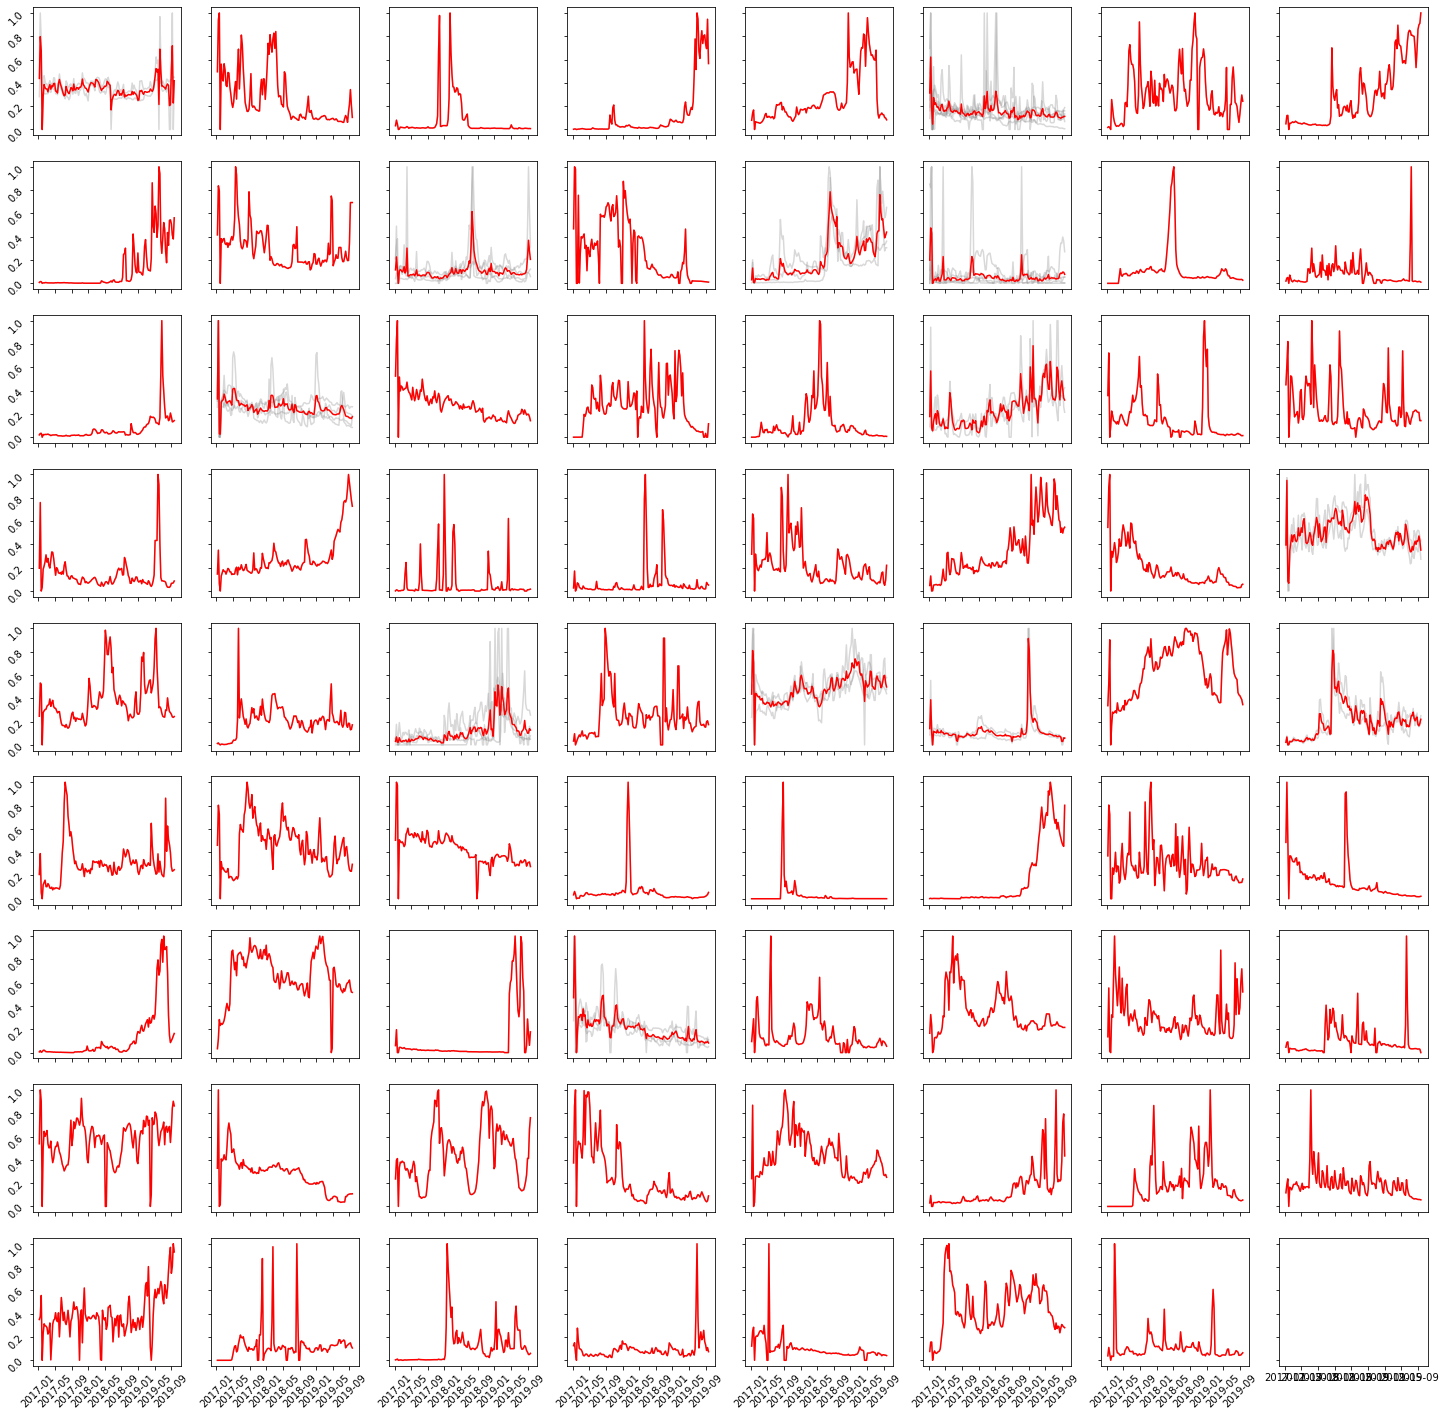

In [29]:
WIDTH = 8

fig,axs = plt.subplots(math.ceil(len(win_map)/WIDTH),WIDTH,figsize=(25,25),sharex=True,sharey=True)

i = 0
j = 0
for cluster in win_map.keys():
    for serie in win_map[cluster]:
        axs[(i,j)].plot(date_index,serie,c="gray",alpha=0.3)
    axs[(i,j)].plot(date_index,np.average(np.vstack(win_map[cluster]),axis=0),c="red")
    axs[(i,j)].tick_params(labelrotation=45)
    j += 1
    if j >= WIDTH:
        i += 1
        j = 0
print(series.shape)

MiniSom determines itself the number of cluster which can be a bit troublesome like here where we almost have one cluster per timeserie.

### KMeans Clustering

In [30]:
from tslearn.clustering import TimeSeriesKMeans
N_CLUSTERS = 10
km = TimeSeriesKMeans(n_clusters=N_CLUSTERS, metric="euclidean", max_iter=100, random_state=0).fit(series)

labelled = list(zip(km.labels_,series))

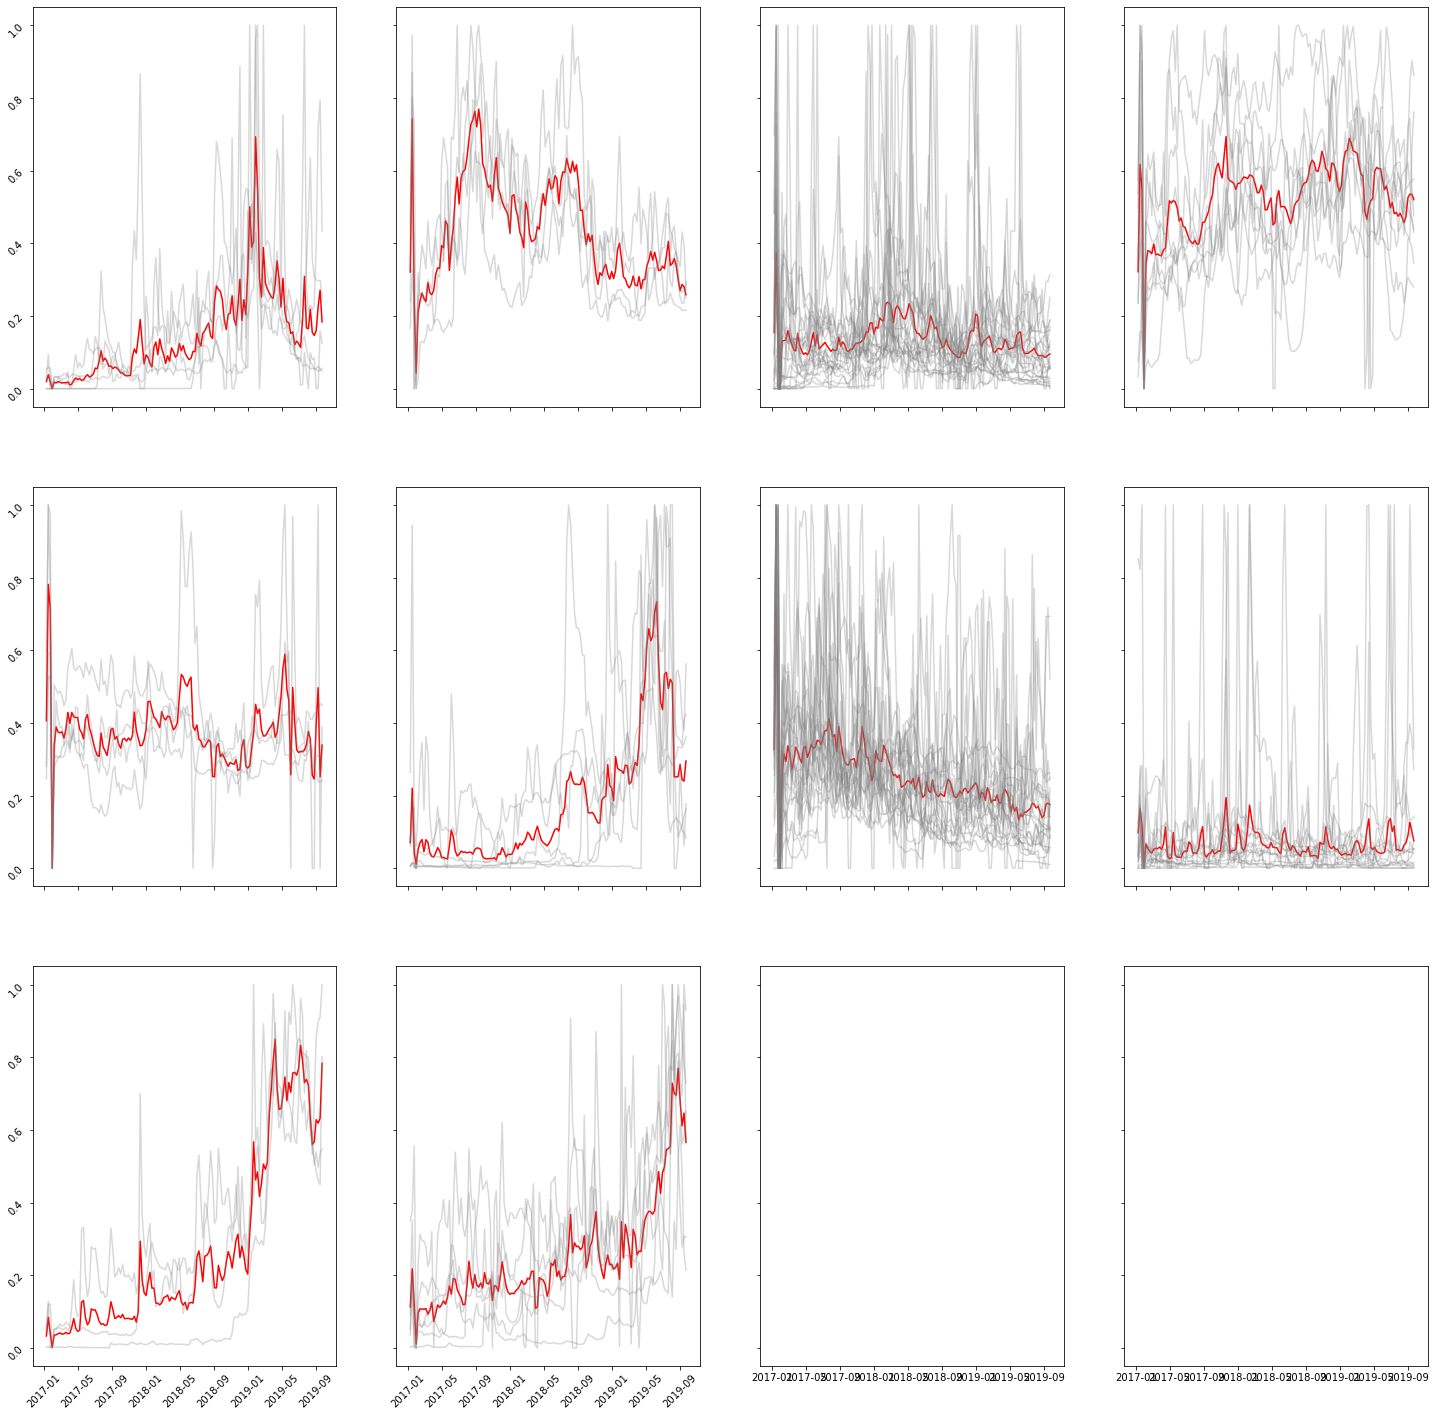

In [31]:
WIDTH = 4

fig, axs = plt.subplots(math.ceil(N_CLUSTERS/WIDTH),WIDTH,figsize=(25,25),sharex=True,sharey=True)

i = 0
j = 0
for cluster in km.cluster_centers_:
    axs[(i,j)].plot(date_index,cluster,c="red")
    axs[(i,j)].tick_params(labelrotation=45)
    j += 1
    if j >= WIDTH:
        i += 1
        j = 0
        
for label,serie in labelled:
    i = math.floor(label/WIDTH)
    j = label%WIDTH
    axs[(i,j)].plot(date_index,serie,c="gray",alpha=0.3)

We took the euclidian distance even if it is not the best for timeseries processing but we had worst results using Dynamic time warping option.

### Birch

In [32]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=10).fit(series)

In [33]:
labelled = list(zip(brc.labels_,series))

unique_labels = set(brc.labels_)
print(unique_labels)

clusters = []
for ulabel in unique_labels:
    if ulabel != -1:
        s = []
        for label,serie in labelled:
            if label == ulabel:
                s.append(serie)
        clusters.append(s)

means = []
for cluster in clusters:
    arrays = [np.array(x) for x in cluster]
    means.append([np.mean(k) for k in zip(*arrays)])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


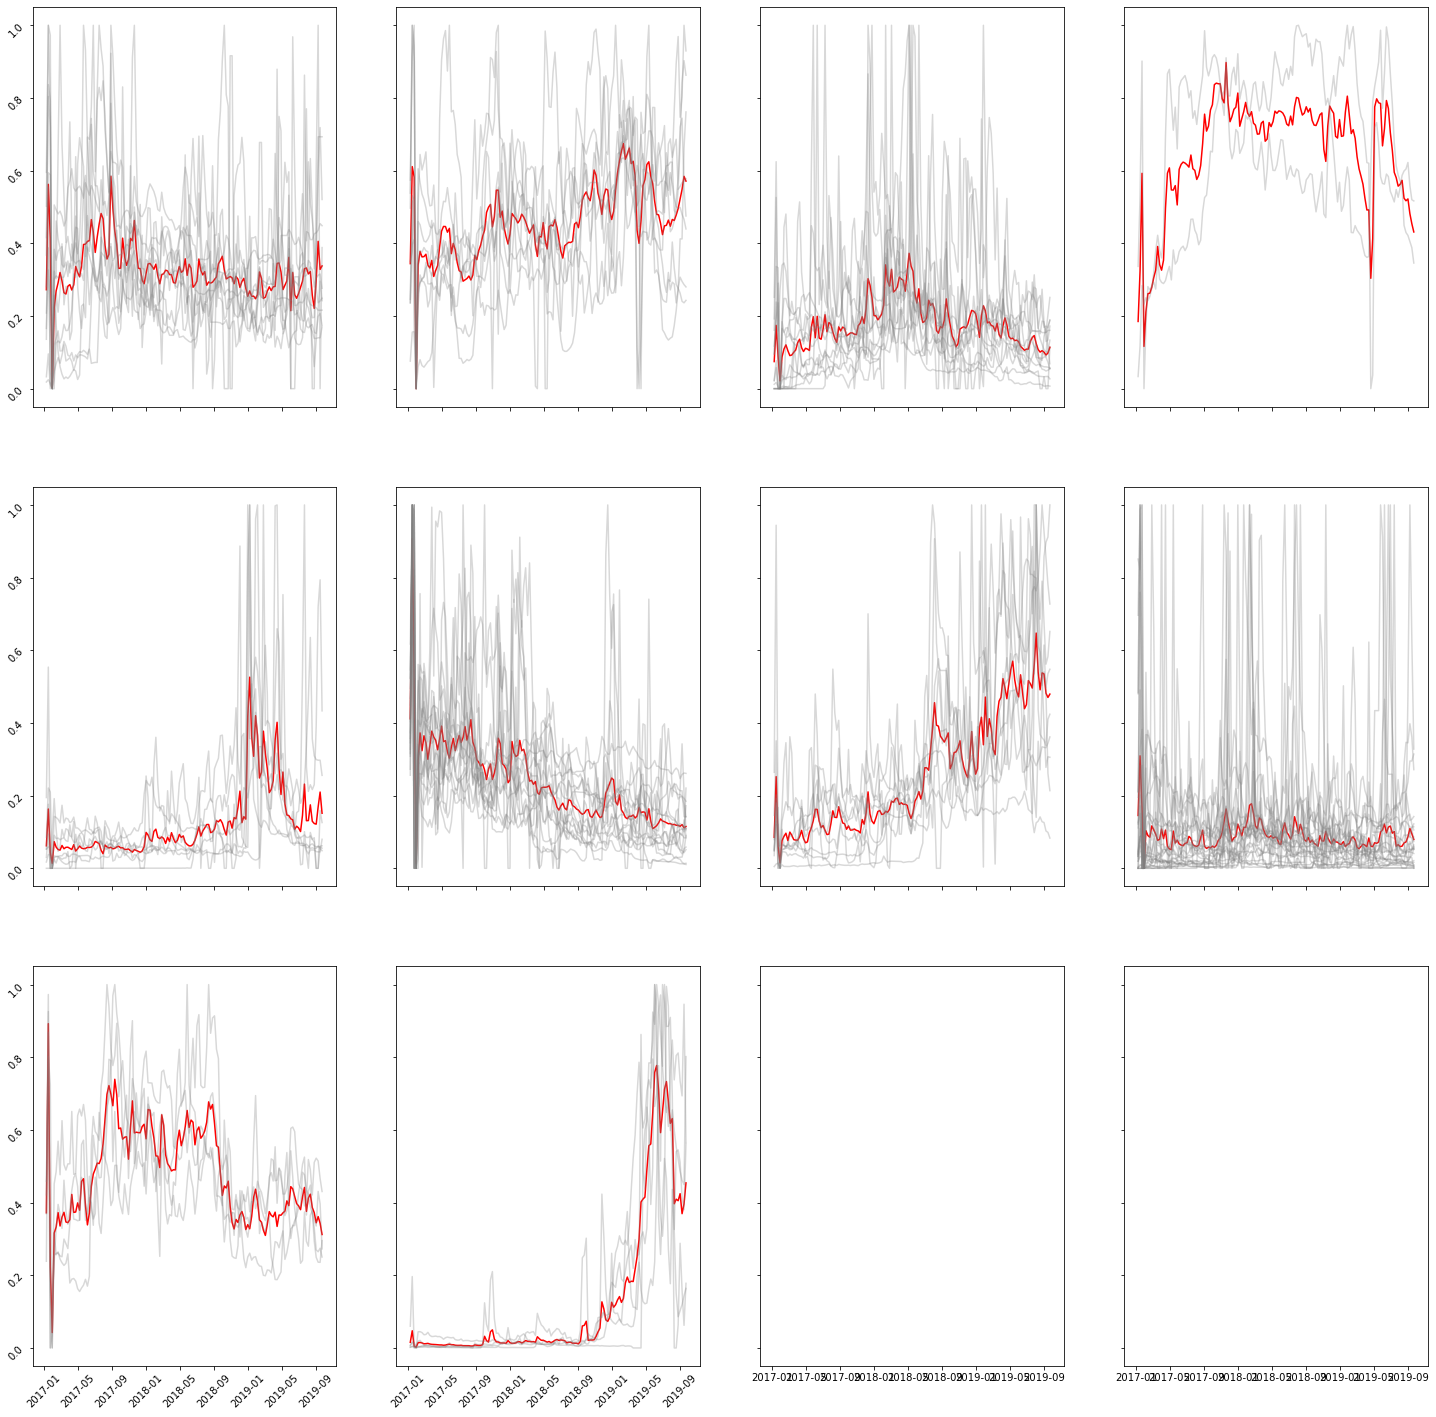

In [34]:
WIDTH = 4

fig, axs = plt.subplots(math.ceil(len(unique_labels)/WIDTH),WIDTH,figsize=(25,25),sharex=True,sharey=True)

i = 0
j = 0
for n in unique_labels:
    axs[(i,j)].plot(date_index,means[n],c="red")
    axs[(i,j)].tick_params(labelrotation=45)
    for serie in clusters[n]:
        axs[(i,j)].plot(date_index,serie,c="gray",alpha=0.3)
    j += 1
    if j >= WIDTH:
        i += 1
        j = 0

We had the best results with this algorithm, probably because it handles well large datasets and outliers. It computes a tree of clusters that is later given to an agglomerative clustering algorithm which will merge clusters to get the wanted number of clusters.

### MeanShift

In [35]:
from sklearn.cluster import MeanShift

ms = MeanShift(bandwidth=2.4).fit(series)

In [36]:
labelled = list(zip(ms.labels_,series))

unique_labels = set(ms.labels_)
print(unique_labels)

clusters = []
for ulabel in unique_labels:
    if ulabel != -1:
        s = []
        for label,serie in labelled:
            if label == ulabel:
                s.append(serie)
        clusters.append(s)

means = []
for cluster in clusters:
    arrays = [np.array(x) for x in cluster]
    means.append([np.mean(k) for k in zip(*arrays)])

{0, 1, 2, 3, 4, 5, 6}


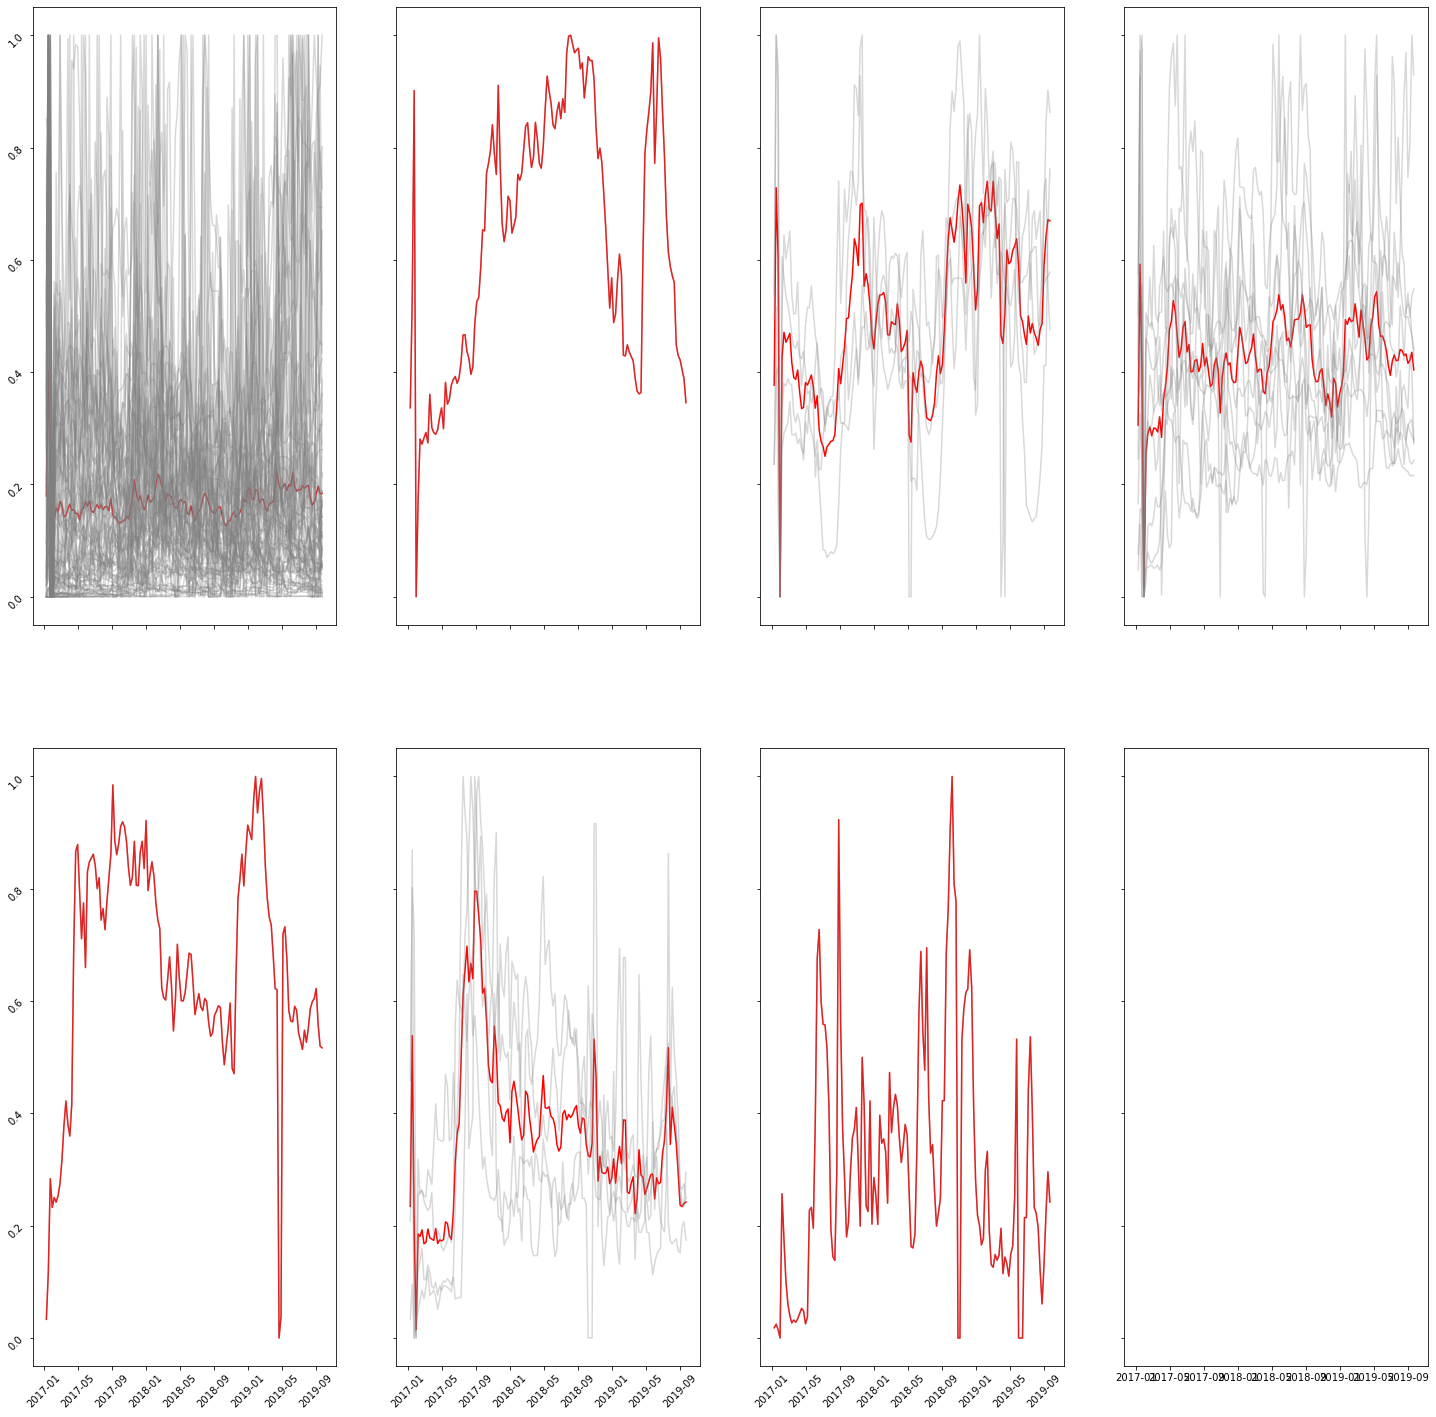

In [37]:
WIDTH = 4

fig, axs = plt.subplots(math.ceil(len(unique_labels)/WIDTH),WIDTH,figsize=(25,25),sharex=True,sharey=True)

i = 0
j = 0
for n in unique_labels:
    axs[(i,j)].plot(date_index,means[n],c="red")
    axs[(i,j)].tick_params(labelrotation=45)
    for serie in clusters[n]:
        axs[(i,j)].plot(date_index,serie,c="gray",alpha=0.3)
    j += 1
    if j >= WIDTH:
        i += 1
        j = 0

MeanShift is supposed to work well with many clusters of uneven size but the results that we get are not very conclusive.